In [1]:
import chaospy as cp
import numpy as np 
from itertools import product, repeat
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def S_t(S_0: float, r: float, sigma: float, t: float, W: float):
    return S_0*np.exp(
        (r-sigma**2)*0.5*t + sigma**W
    )

def geom_asian_payout(S: np.ndarray, K: float):
    d = len(S)
    return 1/d*np.sum(
        max(S-K, 0)
    )

def cov_brownian_bridge(s, t):
    """Entry for covariance martix computed according to
    https://math.stackexchange.com/questions/264067/covariance-of-brownian-bridge.
    Where s < t.

    Args:
        s (float): Time s.
        t (float): Time t.

    Returns:
        float: Covariance of Brownian Bridge
    """
    return s*(1-t) #if s <= t else 0


# Asiatische Option  

Als geläufiges Beispiel für Optionspreisbestimmung wird hier eine asiatische Option bewertet.  
Die geschlossene Formel für asiatische Optionen lautet:
$$ V(S,0)=S(0)\gamma \Phi(\beta+\sigma \sqrt{T_1})-Ke^{-rT}\Phi(\beta) $$
mit 
$$ \gamma:= e^{−r(T −T_2 )−σ^2(T_2 −T_1 )/2} $$
$$ \beta:= \frac{
    ln(S(0)/K)+(r-0.5\sigma^2)T_2
}{\sigma \sqrt{T_1}} $$
$$ T_1 := T-\frac{
    d(d-1)(4d+1)}{6d^2}\Delta t $$
$$ T_2 := T-\frac{d-1}{2} \Delta t$$

![](/home/michael/Pictures/euroasianoptionprice.png)

## Beispiel für $d=16$ Zeitschritte, $S(0)=100, \sigma=0.2, r=0.1, T=1, K=100$

In [3]:
from scipy.stats import norm

S_0 = 100
d = 16
dim = 1
a, b = 0,1
y = np.random.normal(size=d)
I = np.linspace(a,b, d, dtype=np.float32, endpoint=False) + 1/d
sigma = 0.2
r = 0.1
T, delta_t = 1, I[1]-I[0]
K = 100
# T_1 = T - (d*(d-1)*(4*d+1))/(6*d**2)*delta_t
# T_2 = T - 0.5*(d-1)*2
# beta = (np.log(S_0/K)+ (r-0.5*sigma**2)*T_1)/(sigma*np.sqrt(T_1))
# gamma = np.exp(-r*(T-T_2)-sigma**2*(T_2-T_1)/2)


st = np.mgrid[1:d+1, 1:d+1]/d
s, t = st
cov = st.min(axis=0)*sigma**2
A = np.linalg.cholesky(cov)
sigma_g = sigma/np.sqrt(3)
b = 0.5*(r-0.5*sigma_g**2)
d1 = (np.log(S_0/K)+ (b+0.5*sigma_g**2)*T)/(sigma_g*np.sqrt(T))
d2 = d1-sigma_g*np.sqrt(T)
C_G = S_0*np.exp((b-r)*T)*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
print(C_G)

6.769950595122843


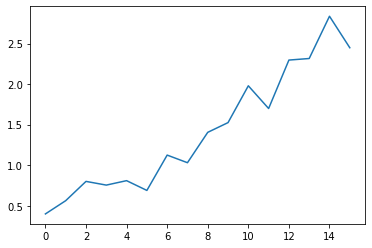

In [4]:
A = np.sqrt(delta_t)* np.tril(np.ones(d)) 
plt.plot(A@y)
#norm.pdf(y)
plt.show()

In [8]:
#cp.generate_quadrature(3)
k1, k2 = -20, 20
iid_dist = cp.Iid(cp.Uniform(k1, k2), 16) 

abscissas, weights =  cp.generate_quadrature(
    3, iid_dist, sparse=True
)
abscissas.shape

(16, 6049)